# Basic Equilibrium

DESC is a 3D MHD equilibrium and optimization code suite, which solves the ideal MHD equilibrium equations to find stellarator equilibria. 

Like VMEC, DESC requires 4 main inputs to define the equilibrium problem:

 - Pressure Profile
 - Rotational Transform or Toroidal Current Profile
 - Last Closed Flux Surface Boundary Shape
 - Total toroidal magnetic flux enclosed by the LCFS

DESC can be run both with a text input file from the command line (e.g. `python -m desc INPUT_FILE`) or through python scripts (which offers more options than the text file for equilibrium solving and optimization). This tutorial notebook will focus on basic functionality for solving an equilibrium.

## Creating an Equilibrium from scratch

The recommended way to work with DESC is through python scripts, in which we construct and solve an `Equilibrium` object.

We initialize the `Equilibrium` with the desired resolution, and the inputs specified above:
- Boundary shape, as a `FourierRZToroidalSurface`
- Profiles, as `Profile` objects (there are several different options, the most common is `PowerSeriesProfile`)
- Total flux `Psi` as a float


If you do not have an input file to work from, you can see the below steps to create an `Equilibrium` from scratch.

When starting from scratch, you can construct the surface by specifying the Fourier coefficients and mode numbers manually.

The boundary is represented by a double Fourier series for R and Z in terms of a poloidal angle $\theta$ and the geometric toroidal angle $\zeta$. We specify the mode numbers for R and Z as 2D arrays of `[m,n]` pairs, and the coefficients as a 1D array.

In DESC the double Fourier series for R and Z are defined in a slightly different manner than VMEC:

$$
\begin{align}
    R^b(\theta,\zeta) &= \sum^M \sum^N R^b_{mn} \mathcal{G}^{m}_{n}(\theta,\zeta)\\
    Z^b(\theta,\zeta) &= \sum^M \sum^N Z^b_{mn} \mathcal{G}^{m}_{n}(\theta,\zeta)
\end{align}
$$

where

$$
   \mathcal{G}^{m}_{n}(\theta,\zeta) = \begin{cases}
   \cos(|m|\theta)\cos(|n|N_{FP}\zeta) &\text{for }m\ge0, n\ge0 \\
   \cos(|m|\theta)\sin(|n|N_{FP}\zeta) &\text{for }m\ge0, n<0 \\
   \sin(|m|\theta)\cos(|n|N_{FP}\zeta) &\text{for }m<0, n\ge0 \\
   \sin(|m|\theta)\sin(|n|N_{FP}\zeta) &\text{for }m<0, n<0.
   \end{cases}
$$

**Note**: in DESC, radial modes are indexed by `l`, poloidal modes by `m`, and toroidal modes by `n`

In [1]:
from desc.equilibrium import Equilibrium
from desc.geometry import FourierRZToroidalSurface
from desc.profiles import PowerSeriesProfile

surf2 = FourierRZToroidalSurface(
    R_lmn=[10.0, -1.0, -0.3, 0.3],
    modes_R=[
        (0, 0),
        (1, 0),
        (1, 1),
        (-1, -1),
    ],  # (m,n) pairs corresponding to R_mn on previous line
    Z_lmn=[1, -0.3, -0.3],
    modes_Z=[(-1, 0), (-1, 1), (1, -1)],
    NFP=19,
)

DESC version 0+untagged.11130.ga9f9ae8,using JAX backend, jax version=0.4.35, jaxlib version=0.4.35, dtype=float64
Using device: CPU, with 32.24 GB available memory


For profiles, we will use the standard `PowerSeriesProfile` which represents a function as a power series in the radial coordinate $\rho$ which is the square root of the normalized toroidal flux: $\rho = \sqrt{\Psi/\Psi_b}$ (Note this is different from VMEC which uses the normalized toroidal flux without the square root). We could also use splines (`SplineProfile`), or Zernike polynomials (`FourierZernikeProfile`), for more options, see the [`desc.profiles` module](https://desc-docs.readthedocs.io/en/stable/api.html#profiles)

In [ ]:
pressure = PowerSeriesProfile(
    [1.8e4, 0, -3.6e4, 0, 1.8e4]
)  # coefficients in ascending powers of rho
iota = PowerSeriesProfile([1, 0, 1.5])  # 1 + 1.5 r^2

Finally, we create the equilibrium using the objects we just made, leaving the other parameters at their defaults. The number of field periods by default is inferred from the given surface.

In [4]:
eq = Equilibrium(
    L=8,  # radial resolution
    M=8,  # poloidal resolution
    N=3,  # toroidal resolution
    surface=surf2,
    pressure=pressure,
    iota=iota,
    Psi=1.0,  # total flux, in Webers
)

We now have an `Equilibrium` object, but it is generally not actually in equilibrium, as the default initial guess is just to scale the outermost flux surface.

To find the actual solution, we must solve the equilibrium. There are two primary ways to do this in DESC:

- `eq.solve` is a method of the `Equilibrium` class that is best used when starting close to the correct solution, or for refining a solution after optimization, for example. Generally not recommended for "cold start" solves.
- `desc.continuation.solve_continuation_automatic` uses a multi-grid continuation method to arrive at a particular desired equilibrium. It is generally very robust, and is the recommended method.

Here, we will use both methods

In [11]:
eq1, info = eq.solve(verbose=3, copy=True)

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 533 ms
Timer: Objective build = 822 ms
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed iota
Building objective: fixed sheet current
Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: lambda gauge
Building objective: axis R self consistency
Building objective: axis Z self consistency
Timer: Objective build = 591 ms
Timer: Linear constraint projection build = 3.00 sec
Number of parameters: 351
Number of objectives: 2106
Timer: Initializing the optimization = 4.43 sec

Starting optimization
Using method: lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          9.095e-01                                    3.829e+01   
       1              2          7.594e-02      8.335e-01      2.539e-01  

In [12]:
from desc.continuation import solve_continuation_automatic

eqf = solve_continuation_automatic(eq.copy(), verbose=3)

Step 1
Spectral indexing: ansi
Spectral resolution (L,M,N)=(6,6,0)
Node resolution (L,M,N)=(12,12,0)
Boundary ratio = 0
Pressure ratio = 0
Perturbation Order = 2
Objective: force
Optimizer: lsq-exact
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 697 ms
Timer: Objective build = 750 ms
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed iota
Building objective: fixed sheet current
Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: lambda gauge
Building objective: axis R self consistency
Building objective: axis Z self consistency
Timer: Objective build = 392 ms
Timer: Linear constraint projection build = 2.04 sec
Number of parameters: 27
Number of objectives: 98
Timer: Initializing the optimization = 3.21 sec

Starting optimization
Using method: lsq-exact
   Iteration     Total nfev        Cost      Cost reduction

`solve_continuation_automatic` starts with a low resolution vacuum axisymmetric solution, and proceeds to increase the pressure, boundary shaping, and resolution until the final desired configuration is reached. It returns not just the final equilibrium, but each step along the way, as an `EquilibriaFamily`. 

Finally, we can look at the differences between the two methods, and the initial guess

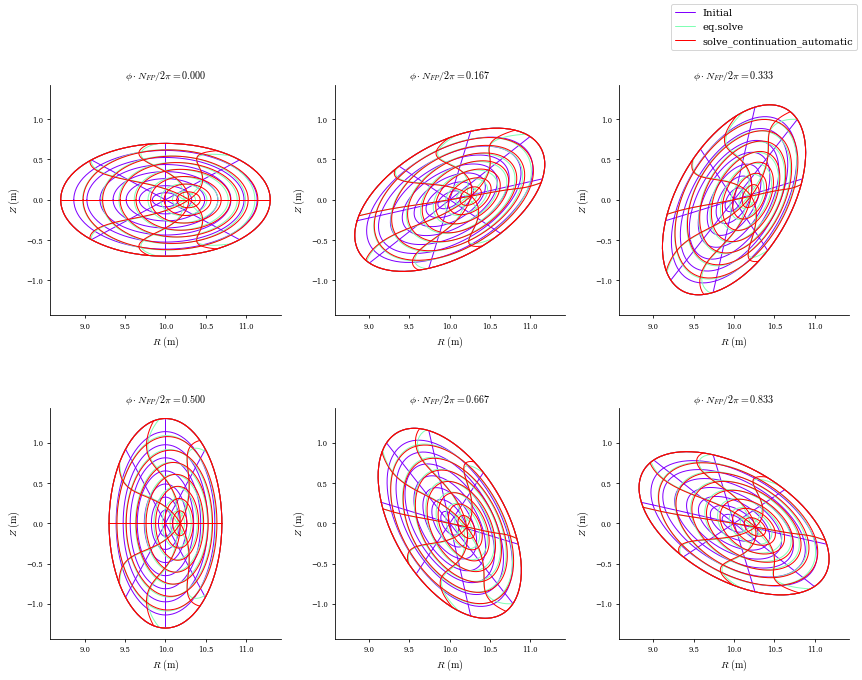

In [13]:
plot_comparison(
    [eq, eq1, eqf[-1]], labels=["Initial", "eq.solve", "solve_continuation_automatic"]
);

If we compute the normalized force balance error for each case, we see that using the continuation method gives ~20% lower error, indicating a better solution. For more complex equilibria this difference will often be much larger, which is why the continuation method is usually recommended.

In [14]:
f1 = (
    eq1.compute("<|F|>_vol")["<|F|>_vol"]
    / eq1.compute("<|grad(|B|^2)|/2mu0>_vol")["<|grad(|B|^2)|/2mu0>_vol"]
)
f2 = (
    eqf[-1].compute("<|F|>_vol")["<|F|>_vol"]
    / eqf[-1].compute("<|grad(|B|^2)|/2mu0>_vol")["<|grad(|B|^2)|/2mu0>_vol"]
)
print(f"Force error after eq.solve(): {f1:.4e}")
print(f"Force error after solve_continuation_autmatic: {f2:.4e}")

Force error after eq.solve(): 9.3711e-03
Force error after solve_continuation_autmatic: 7.3831e-03
